In [1]:
%matplotlib inline

import laueimproc
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch

In [2]:
def geometry(idx: int) -> tuple[int, int]:
    return (idx%151, idx//151)
dataset = laueimproc.DiagramsDataset("/data/scan0001", position=geometry)

In [3]:
def peaks_search(diag: laueimproc.Diagram) -> torch.Tensor:
    diag.find_spots(density=0.5)
    return diag.compute_rois_centroid()
bary = dataset.apply(peaks_search)

peaks_search: 100%|██████████████████████████████████████████| 22801/22801 [14:42<00:00, 25.82diag/s]


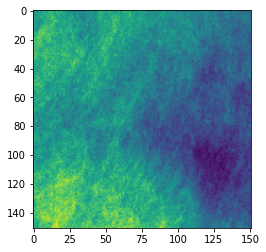

In [4]:
nbr_spots = np.empty((151, 151), dtype=int)
for x in range(151):
    for y in range(151):
        nbr_spots[y, x] = len(dataset[x, y])
plt.imshow(nbr_spots)
plt.show()

In [5]:
from laueimproc.clustering.spot_dist import associate_spots, group_spots, track_spots, spotslabel_to_diag

In [6]:
diags = []
for x in range(151):
    for y in range(150):
        idx = x + 151*y
        diags.append((idx, idx+151))
for x in range(150):
    for y in range(151):
        idx = x + 151*y
        diags.append((idx, idx+1))
diags = torch.tensor(diags, dtype=int)  # indices des diagrams voisins

In [7]:
assert len(bary) == 151*151, "wait, somme diagram are missing"
pos = [bary[i] for i in sorted(bary)]  # la position de chaque spot

In [8]:
pairs = [associate_spots(pos[i], pos[j], eps=0.25) for i, j in tqdm.tqdm(diags.tolist())]  # les couples de spot
print(f"il y a en moyenne {sum(map(len, pairs))/len(pairs)} paires par voisin")

100%|█████████████████████████████████████████████████████████| 45300/45300 [01:20<00:00, 561.62it/s]

il y a en moyenne 42.80344370860927 paires par voisin


In [9]:
labels = track_spots(pairs, diags)  # diagram idx -> (spot_idx, spot_label) 
sl2d = spotslabel_to_diag(labels)  # spot_label -> diagrams_indices
print(f"il y a {len(sl2d)} labels de spot partagant en moyenne {sum(map(len, sl2d.values()))/len(sl2d)}")

il y a 1326556 labels de spot partagant en moyenne 2.4406832429237815


In [12]:
# use DBCAN of scikit learn
sl2d = {s: diags for s, diags in sl2d.items() if len(diags) >= 5}

dataset = list(sl2d.values())
def dist_func(idx1, idx2):
    return jaccard_dist_set(dataset[round(idx1.item())], dataset[round(idx2.item())])

from sklearn.cluster import DBSCAN
print("avant")
reduced_dataset = DBSCAN(metric=dist_func, n_jobs=-1).fit(np.arange(len(dataset)).reshape(-1, 1))
print("apres")

# clusters = group_spots(sl2d)

avant
apres


In [11]:
# flatten diags set
total = sum(map(len, sl2d.values()))
set_data = np.empty(total, dtype=np.int64)
sl2d_flat = {}
start = 0
for spot_lbl, diags in sl2d.items():
    end = start + len(diags)
    set_data[start:end] = sorted(diags)
    sl2d_flat[spot_lbl] = set_data[start:end]
    start = end
    
def jaccard_dist_arr(set1: np.ndarray, set2: np.ndarray) -> float:
    """Compute the jaccard distance between the two sorted sets of numbers."""
    dist = 0
    i = j = 0
    while i < len(set1) and j < len(set2):
        if set1[i] <= set2[j]:
            dist += set1[i] == set2[j]
            i += 1
        else:
            j += 1
    return 1 - dist / (len(set1) + len(set2) - dist)

def jaccard_dist_set(set1: set, set2: set) -> float:
    """Compute the jaccard distance between two general sets."""
    dist = len(set1 & set2)
    return 1 - dist / (len(set1) + len(set2) - dist)

In [ ]:
# compute the matrix of distances, using the Jaccard set norm
dist_matrix = np.zeros((len(sl2d), len(sl2d)), dtype=np.float32)
spot_labels = list(sl2d)
diag_sets = [sl2d[s] for s in spot_labels]  # not .values() for order
for i, set1 in tqdm.tqdm(enumerate(diag_sets[:-1]), total=len(diag_sets)-1):
    for j, set2 in zip(range(i+1, len(diag_sets)), diag_sets[i+1:]):
        jaccard_dist_set(set1, set2)
        # dist_matrix[i, j] = jaccard_dist_set(set1, set2)
dist_matrix += dist_matrix.transpose()

In [ ]:
# compute the matrix of distances, using the Jaccard arr norm
dist_matrix = np.zeros((len(sl2d), len(sl2d)), dtype=np.float32)
spot_labels = list(sl2d)
diag_sets = [sl2d_flat[s] for s in spot_labels]  # not .values() for order
for i, set1 in tqdm.tqdm(enumerate(diag_sets[:-1]), total=len(diag_sets)-1):
    for j, set2 in zip(range(i+1, len(diag_sets)), diag_sets[i+1:]):
        jaccard_dist_arr(set1, set2)
        # dist_matrix[i, j] = jaccard_dist_arr(set1, set2)
dist_matrix += dist_matrix.transpose()

In [ ]:
inv_clusters = {}
for spot_label, diags in sl2d.items():
    diags = frozenset(diags)
    inv_clusters[diags] = inv_clusters.get(diags, set())
    inv_clusters[diags].add(spot_label)
inv_clusters = {diags: spots_labels for diags, spots_labels in inv_clusters.items() if len(spots_labels) >= 3}
clusters = [spot_labels for i, spot_labels in enumerate(inv_clusters.values())]  # regroupe les spots_labels

In [ ]:
# passe des labels de spots aux couples (diagram index / spot index)
clusters = [{diag_idx: spot_lbl for spot_lbl in spot_lbls for diag_idx in sl2d[spot_lbl]} for spot_lbls in clusters]
tmp = {diag: {lbl: idx for idx, lbl in idx2lbl.tolist()} for diag, idx2lbl in labels.items()}
clusters = [{diag: tmp[diag][spotlbl] for diag, spotlbl in diag2spotlbl.items()} for diag2spotlbl in clusters]